In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv(r'\Video_Games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [4]:
df.shape

(16719, 16)

In [5]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.drop(columns=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], inplace=True)

In [8]:
df.replace('tbd', np.nan, inplace=True)

In [9]:
df['user_score'] = df['user_score'].astype('float')

In [10]:
df['user_score'] = df['user_score'] * 10

In [11]:
cat_map = {'PS':'PS', 'PS2':'PS', 'PS3':'PS', 'PS4':'PS', 'PSV':'PS', 'PSP':'PS', 'DS':'Nintendo', 'Wii':'Nintendo', 'GBA':'Nintendo',
          'GC':'Nintendo', '3DS':'Nintendo', 'SNES':'Nintendo', 'N64':'Nintendo', 'WiiU':'Nintendo', 'NES':'Nintendo', 'GB':'Nintendo',
          'X360':'Microsoft', 'XB':'Microsoft', 'XOne':'Microsoft', 'PC':'PC'}

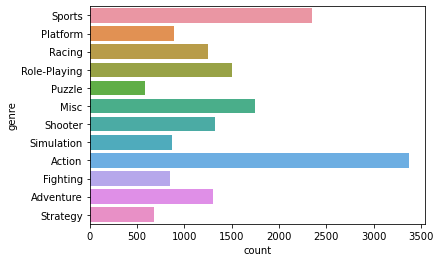

In [12]:
sns.countplot(y='genre', data=df);

Action is the most popular genre.

In [13]:
df['major_platform'] = df['platform'].map(cat_map)

In [14]:
df_clean = df.dropna(subset=['critic_score', 'user_score'], how='any')

In [15]:
df.major_platform.value_counts()

PS           6723
Nintendo     6271
Microsoft    2333
PC            974
Name: major_platform, dtype: int64

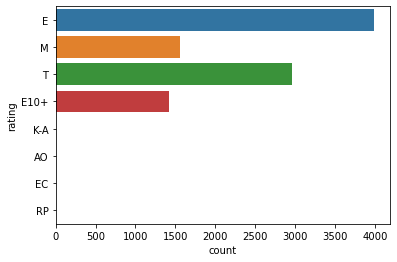

In [16]:
sns.countplot(y='rating', data=df);

In [17]:
top_selling = df.groupby('name')['global_sales'].sum().sort_values(ascending=False).head(10)

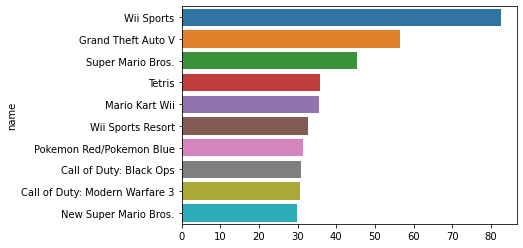

In [18]:
sns.barplot(y=top_selling.index, x=top_selling.values);

In [19]:
median_critic = df_clean.groupby('major_platform')['critic_score'].median().drop('PC')

In [20]:
median_sales = df_clean.groupby('major_platform')['global_sales'].median().drop('PC')

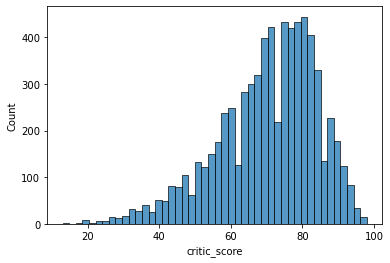

In [21]:
sns.histplot(x='critic_score', data=df_clean);

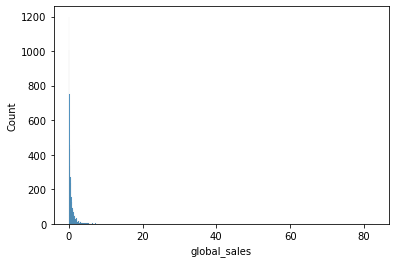

In [22]:
sns.histplot(x='global_sales', data=df_clean);

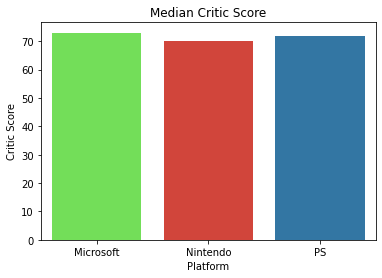

In [23]:
colors = ["#66f443", '#ea2f22', '#2079b6']
customPalette = sns.set_palette(sns.color_palette(colors))
sns.barplot(x=median_critic.index, y=median_critic, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('1.png');

Those 3 platforms are performing similarly in term of critic_score. However, there maybe the cross platform games that influence the result. Next, we will look at only platform exclusive game to determine who sells the best games.

In [24]:
exclusive_median = df_clean.drop_duplicates(subset='name', keep=False).groupby('major_platform')['critic_score'].median().drop('PC')

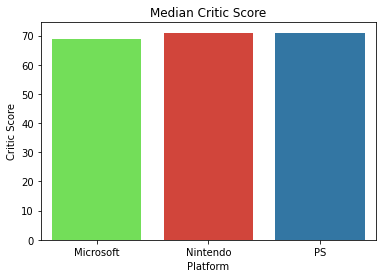

In [25]:
sns.barplot(x=exclusive_median.index, y=exclusive_median, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('2.png');

Seem like there is no different at all! 

In [26]:
exclusive_count = df_clean.drop_duplicates(subset='name', keep=False).query('critic_score >= 80')['major_platform'] \
.value_counts(normalize=True).sort_values().drop('PC')

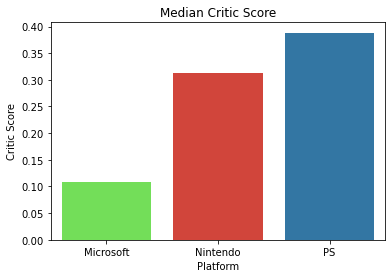

In [27]:
sns.barplot(x=exclusive_count.index, y=exclusive_count, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('3.png');

We now finally have a clear winner! The game that exclusively available for sony has the highest proportion of the good game. Nintendo is coming behind. and then Microsoft.

We see this in the aspect of critic score, but do this result implies in term of sales count. Next, we will try to determine the influence of critic score to sales count.

In [28]:
df_clean.drop_duplicates(subset='name', keep=False).query('major_platform == "Microsoft"')

,name,platform,year_of_release,genre,publisher,global_sales,critic_score,critic_count,user_score,user_count,developer,rating,major_platform
14,Kinect Adventures!,X360,2010.0,Misc,Microsoft Game Studios,21.81,61.0,45.0,63.0,106.0,Good Science Studio,E,Microsoft
44,Halo 3,X360,2007.0,Shooter,Microsoft Game Studios,12.12,94.0,86.0,78.0,4100.0,"Bungie Software, Bungie",M,Microsoft
64,Halo: Reach,X360,2010.0,Shooter,Microsoft Game Studios,9.86,91.0,99.0,79.0,2045.0,Bungie,M,Microsoft
66,Halo 4,X360,2012.0,Shooter,Microsoft Game Studios,9.71,87.0,87.0,70.0,3260.0,343 Industries,M,Microsoft
117,Gears of War 2,X360,2008.0,Shooter,Microsoft Game Studios,6.75,93.0,90.0,77.0,2739.0,Epic Games,M,Microsoft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16196,Grooverider: Slot Car Thunder,XB,2003.0,Racing,Encore,0.01,45.0,9.0,73.0,8.0,King of the Jungle,E,Microsoft
16314,Banjo-Kazooie,X360,2008.0,Platform,Microsoft Game Studios,0.01,77.0,17.0,82.0,70.0,4J Studios,E,Microsoft
16396,Goat Simulator,XOne,2016.0,Simulation,Koch Media,0.01,53.0,15.0,63.0,63.0,Coffee Stain Studios,T,Microsoft
16459,Powerdrome,XB,2004.0,Racing,Evolved Games,0.01,69.0,12.0,70.0,9.0,Argonaut Games,T,Microsoft


In [29]:
exclusive_median

major_platform
Microsoft    69.0
Nintendo     71.0
PS           71.0
Name: critic_score, dtype: float64

In [30]:
median_sales = df_clean.groupby('major_platform')['global_sales'].median()

In [31]:
top_selling_by_plat = df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(10)

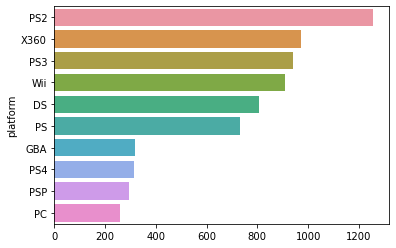

In [32]:
sns.barplot(y=top_selling_by_plat.index, x=top_selling_by_plat.values);

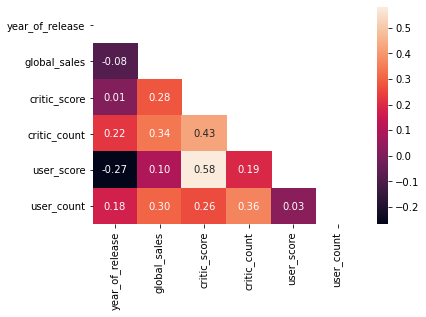

In [33]:
corr= df.corr()
matrix = np.triu(corr)
fig = sns.heatmap(df.drop(0, axis=0).corr(), annot=True, mask=matrix, fmt='.2f').get_figure()
fig.savefig('4.png', bbox_inches="tight");

Interstingly, there seem to be a strong correlation between user_score and critic_score. It's probable that user and critic have the same preference. Or there can hardly be any difference between these two groups at all. Note that this is just a intuition that straightly come right to my mind, we have to test our hypothesis via statistical method to confirm this intuition.

<AxesSubplot:xlabel='user_score', ylabel='critic_score'>

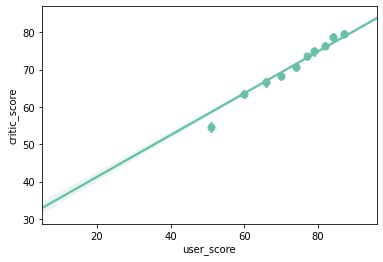

In [34]:
sns.set_palette(sns.color_palette("Set2"))
sns.regplot(x='user_score', y='critic_score', data=df, x_bins=10)

<AxesSubplot:xlabel='user_score', ylabel='global_sales'>

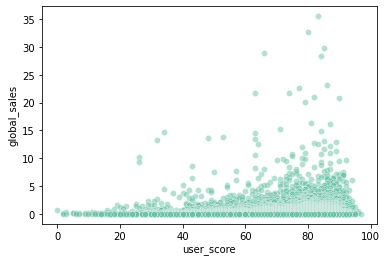

In [35]:
sns.scatterplot(x='user_score', y='global_sales', data=df.drop(0, axis=0), alpha=0.5)

<AxesSubplot:xlabel='user_score', ylabel='global_sales'>

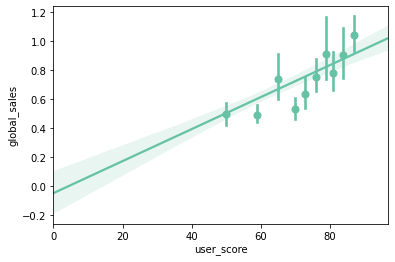

In [36]:
sns.regplot(x='user_score', y='global_sales', data=df, x_bins=10)

<AxesSubplot:xlabel='critic_score', ylabel='global_sales'>

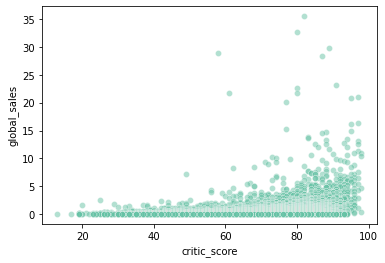

In [37]:
sns.scatterplot(x='critic_score', y='global_sales', data=df.drop(0, axis=0), alpha=0.5)

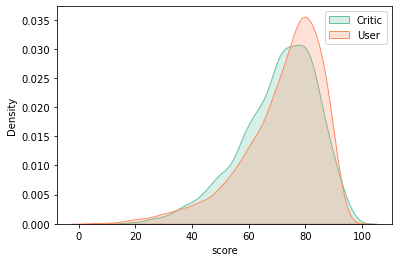

In [62]:
fig, axes = plt.subplots()
sns.kdeplot(x='critic_score', data=df[~(df.user_score.isna() | df.critic_score.isna())], fill=True, label='Critic', axes=axes)
sns.kdeplot(x='user_score', data=df[~(df.user_score.isna() | df.critic_score.isna())], fill=True, label= 'User', axes=axes)
axes.set_xlabel('score')
axes.legend()
fig.savefig('kde.png')

From the graph, we can see that both user_score and critic_score distribution are quite left-skewed. And seem like my intuition was wrong as the users on average give higher scores than critics. To be sure, we will perform bootstrap test for difference between means. I choose this method because it doesn't require a lot of assumptions like t-test and the test itself doesn't require much of the theory, so it's quite easy to understand. We can now state our Null and Alternative hypothesis as follows:
- H0: Mean differences between user_score and critic_score = 0
- H1: Mean differences between user_score and critic_score != 0

In [39]:
def bootstrap_mean(data):
    bs_sample = np.random.choice(data, len(data))
    return np.mean(bs_sample)

In [40]:
user = df.user_score[~(df.user_score.isna() | df.critic_score.isna())].ravel()
critic = df.critic_score[~(df.user_score.isna() | df.critic_score.isna())].ravel()

In [41]:
def draw_bs_reps(data, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_mean(data)
    return bs_replicates

In [42]:
mean_score = np.mean(np.concatenate((user, critic), axis=None))

user_shifted = user - np.mean(user) + mean_score
critic_shifted = critic - np.mean(critic) + mean_score 

bs_replicates_user = draw_bs_reps(user_shifted, 100000)
bs_replicates_critic = draw_bs_reps(critic_shifted, 100000)


bs_replicates = bs_replicates_user - bs_replicates_critic

empirical_mean = np.mean(user) - np.mean(critic)

p = sum(bs_replicates >= empirical_mean) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


In [43]:
user

array([80., 83., 80., ..., 58., 72., 58.])

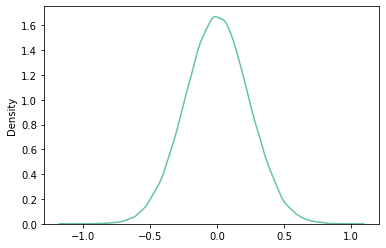

In [44]:
fig, axes = plt.subplots()
sns.kdeplot(bs_replicates);

In [45]:
mean_diff = draw_bs_reps(user - critic, 100000)

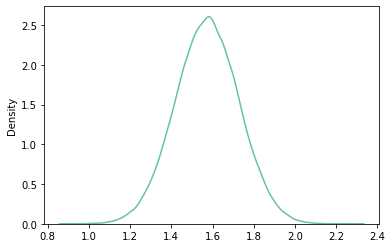

In [46]:
sns.kdeplot(mean_diff);

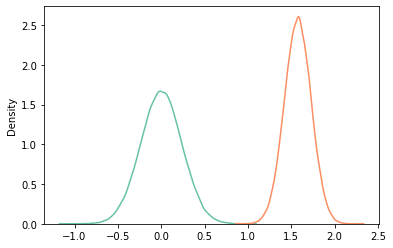

In [47]:
axes = sns.kdeplot(bs_replicates);
axes = sns.kdeplot(mean_diff);

In [48]:
np.percentile(bs_replicates, [2.5, 97.5])

array([-0.46743623,  0.46401596])

In [49]:
np.percentile(mean_diff, [2.5, 97.5])

array([1.26991236, 1.87672795])

In [50]:
empirical_mean

1.5744620208066067

### What drive sales of video games
Do critic score influence the sales of video games? It seem resonable to think so. People usually collects a lot of information before making a decision. What about the variety of genre, platform, or publisher? Do the customers prefer one over another? We will use a machine learning algorithm to answer these questions.

The model I attempt to create to predict sales of video games based on the following variables:
- Genre
- Platform of release
- Publisher
- Metacritic score
- Year of release
<br>

(I avoid using user related variables to prevent 'data leakage' probkem)

In [51]:
def remove_low_publisher(df, thresh):
    new_df = df.drop(df[df.publisher.isin(df.publisher.value_counts()[df.publisher.value_counts() < thresh].index)].index, axis=0)
    return new_df

In [52]:
def train_test_prep(df):
    X = df[['platform', 'genre', 'publisher','critic_score']]
    y = df[['global_sales']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    train_enc = ohe.fit_transform(X_train[['platform', 'genre', 'publisher']])
    test_enc = ohe.transform(X_test[['platform', 'genre', 'publisher',]])
    
    ohe_train = pd.DataFrame(train_enc, columns=ohe.get_feature_names(input_features=['platform', 'genre', 'publisher']))
    ohe_test = pd.DataFrame(test_enc, columns=ohe.get_feature_names(input_features=['platform', 'genre', 'publisher']))
    
    X_train_new = X_train.drop(columns=['platform', 'genre', 'publisher',])
    X_test_new = X_test.drop(columns=['platform', 'genre', 'publisher',])
    X_train = pd.concat([X_train_new.reset_index(), ohe_train.reset_index()], axis=1)
    X_test = pd.concat([X_test_new.reset_index(), ohe_test.reset_index()], axis=1)
    X_train.drop(columns='index', inplace=True)
    X_test.drop(columns='index', inplace=True)
    
    return X_train, X_test, y_train, y_test

In [53]:
def fit_and_predict_model(X_train, X_test, y_train, y_test):
    xgb = XGBRegressor(random_state=42, subsample=0.7, n_estimators = 500, max_depth=10, learning_rate=0.01,
                       colsample_bytree=0.9, colsample_bylevel=0.8)
    xgb.fit(X_train, y_train)
    y_train_preds = xgb.predict(X_train)
    y_test_preds = xgb.predict(X_test)
    print(f'r2 train: {r2_score(y_train, y_train_preds)}')
    print(f'r2 test: {r2_score(y_test, y_test_preds)}')
    print(f'mae train: {mean_absolute_error(y_train, y_train_preds)}')
    print(f'mae test: {mean_absolute_error(y_test, y_test_preds)}')
    return xgb

In [54]:
# df_prep = remove_low_publisher(df_clean_1, 50)
X_train, X_test, y_train, y_test = train_test_prep(df_clean)
xgb = fit_and_predict_model(X_train, X_test, y_train, y_test)

r2 train: 0.8794481017875971
r2 test: 0.40824212097892876
mae train: 0.3544021824808317
mae test: 0.542945183025742


In [55]:
shap.initjs()

In [56]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


After we successfully train our model. We will try to answer the question that what drives video game sales by understand the influence of specific variables on a prediction made.

In [57]:
df.iloc[2735]

name               Tony Hawk's Underground 2
platform                                  XB
year_of_release                       2004.0
genre                                 Sports
publisher                         Activision
global_sales                            0.75
critic_score                            83.0
critic_count                            55.0
user_score                              78.0
user_count                              12.0
developer            Neversoft Entertainment
rating                                     T
major_platform                     Microsoft
Name: 2735, dtype: object

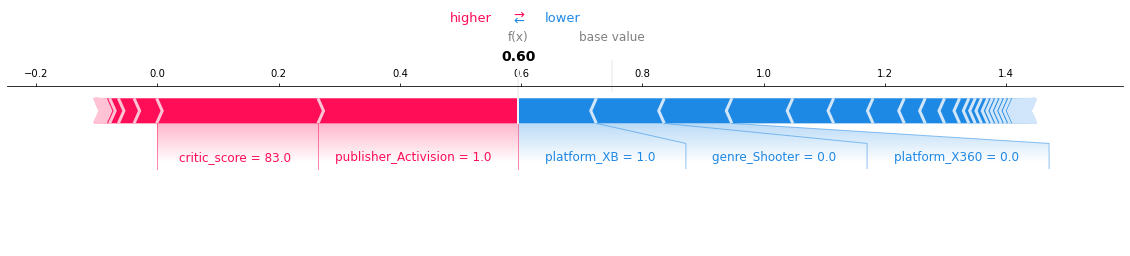

In [58]:
i = 3
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns,
                matplotlib=True, show=False).savefig('shapforce.png', bbox_inches="tight")

The shapely force plot shows the impact of the variables on one specific example. (Here's the resource describe how shapley force plot work.) This one shows the prediction of the game called "Tony Hawk's Underground 2" in the XBOX platform. The way to interpret this graph is pretty simple. Pink color indicate feature that increase the target variable which is sales, and the blue color do the opposite. (FYI. 1 represent presence, 0 represent absence)

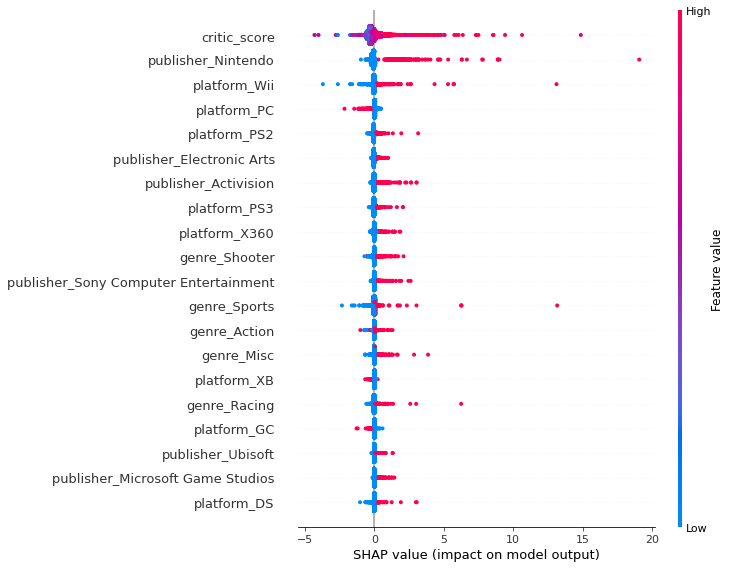

In [59]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

The chart below shows 20 most important features that influence the sales the most. Unsurprisingly, critic_score is the top of the list, as people decision usually depends on the internet reviews (including ME!).

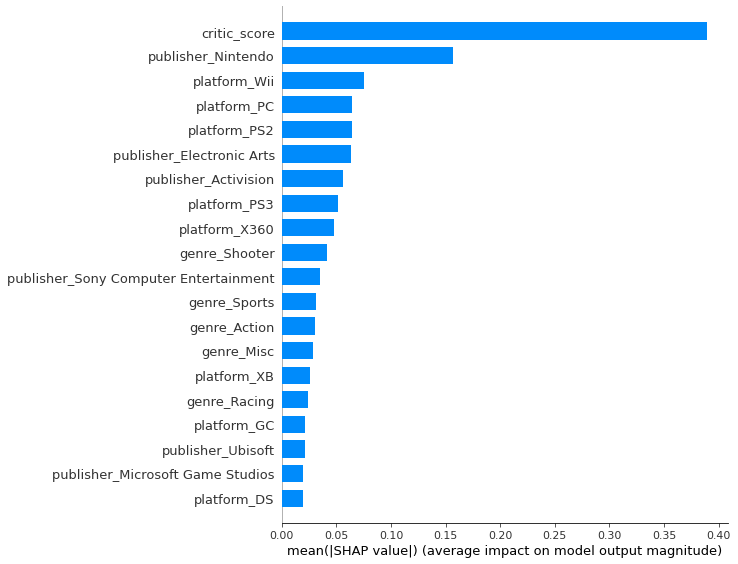

In [60]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar',  show=False)
plt.savefig('grafic.png', bbox_inches="tight");